In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utilities import draw_samples, render_flow_gif, plot_samples, affine_transformation
from utilities_3d import read_vtk, plot_samples_3d, render_flow_gif_3d, affine_transformation_3d
from robot_flows import smooth_robot_registration, wasserstein_flow, apply_spline_robot, apply_anisotropic_spline_robot

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

Using device: cpu


# 2D

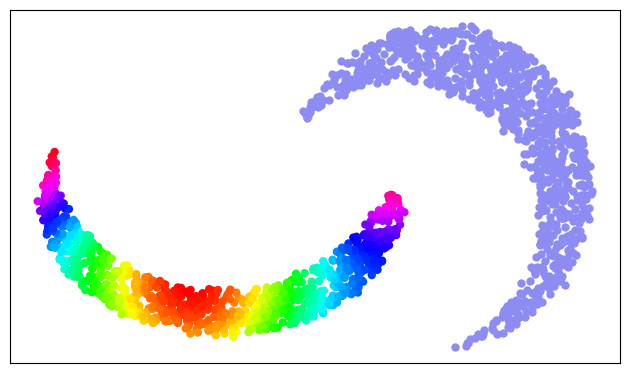

In [31]:
N, M = (1000, 1000) if not use_cuda else (10000, 10000)

X_i = draw_samples("data/moon_a.png", N, dtype).to(device)

theta = np.pi / 4  
scale = 1.8
translation = [0.5, -0.5]
noise = 0.0

#Y_j = affine_transformation(X_i, theta, scale, translation, noise, device, dtype)
Y_j = draw_samples("data/moon_b.png", M, dtype).to(device)


A_i = torch.ones((N, 1), device=device) / N
B_j = torch.ones((1, M), device=device) / M

colors = (np.cos(10 * X_i[:, 0].cpu().numpy()) + np.cos(10 * X_i[:, 1].cpu().numpy()))

plot_samples(X_i, Y_j, colors)

## Wasserstein flows

In [139]:
lr = 0.05
epsilon = 0.001
rho = 0.2
threshold = None

100%|██████████| 101/101 [00:01<00:00, 75.57it/s]


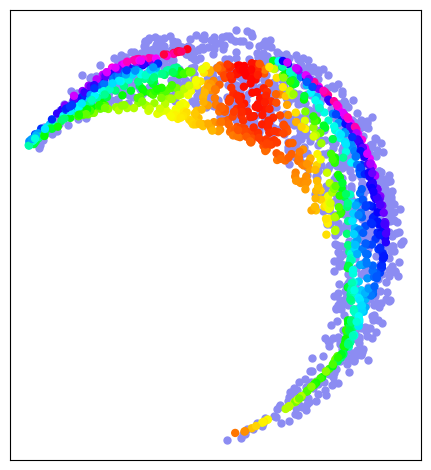

In [140]:
x_final, history = wasserstein_flow(X_i, Y_j, A_i, B_j, lr, epsilon, rho, save_history=True)

plot_samples(x_final, Y_j, colors)

In [141]:
render_flow_gif(history, X_i, Y_j, threshold, "wasserstein_flows.gif")

Render (60 frames)...
GIF saved : wasserstein_flows.gif


## Registration

In [197]:
mode = 'affine'
epsilon = 0.01
rho = 200.2
Nsteps = 20
threshold = None

100%|██████████| 21/21 [00:00<00:00, 51.76it/s]


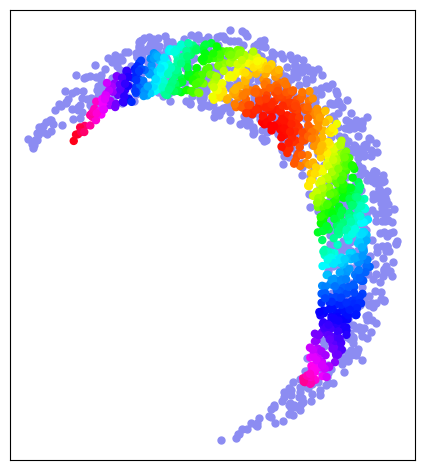

In [198]:
A, h, x_final, history = smooth_robot_registration(X_i, Y_j, A_i, B_j, mode=mode, epsilon=epsilon, rho=rho, Nsteps=Nsteps)
plot_samples(x_final, Y_j, colors)

In [55]:
render_flow_gif(history, X_i, Y_j, threshold, "robot_registration.gif", fps=7)

Render (31 frames)...
GIF saved : robot_registration.gif


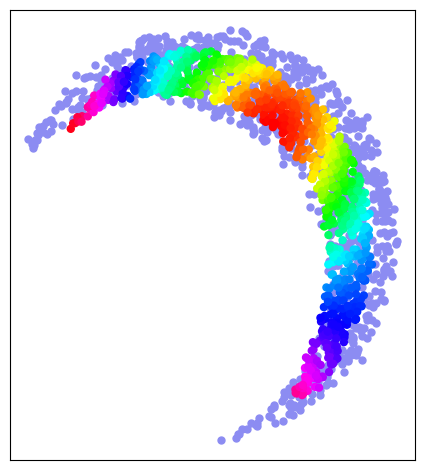

In [206]:
x_final_spline = apply_spline_robot(x_final, Y_j, A_i.flatten(), B_j.flatten(), epsilon=epsilon, rho=rho, sigma_spline=0.05)
plot_samples(x_final_spline, Y_j, colors)

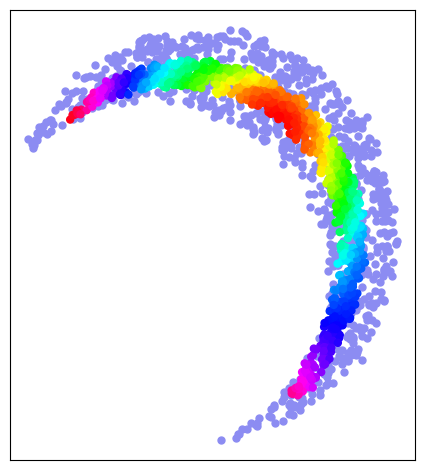

In [209]:
x_final_spline = apply_anisotropic_spline_robot(x_final, Y_j, A_i.flatten(), B_j.flatten(), epsilon=epsilon, rho=rho, sigma_spline=2.5)
plot_samples(x_final_spline, Y_j, colors)

# 3D

In [3]:
X_i, A_i = read_vtk("data/divide_3d_cube_level4.vtk")
#Y_j, B_j = read_vtk("data/divide_3d_sphere_level1.vtk")
print("Loaded", X_i.shape[0], "points")

Y_j = affine_transformation_3d(X_i, theta_x=np.pi/6, theta_y=0, theta_z=0, scale=1.0, translation=[2.3, -0.2, 0.1], noise=0.0, device=device, dtype=dtype)
B_j = A_i

N,M = X_i.shape[0], Y_j.shape[0]

#colors = (np.cos(10 * X_i[:, 0].cpu().numpy()) + np.cos(10 * X_i[:, 2].cpu().numpy()))
colors = X_i[:, 1].cpu().numpy()
#colors = np.ones((N,))

plot_samples_3d(X_i, Y_j, a=A_i, b=B_j, scale_factor=1.)

Loaded 1538 points


/Users/clementgilli/.pyenv/versions/gda/lib/python3.12/site-packages/pyvista/core/filters/data_set.py:1802: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn(


Widget(value='<iframe src="http://localhost:58937/index.html?ui=P_0x15efc6210_0&reconnect=auto" class="pyvista…

In [7]:
mode = 'rigid'
epsilon = 0.001
rho = 0.2
Nsteps = 20

#x_final, history = wasserstein_flow(X_i, Y_j, A_i, B_j, lr=0.05, epsilon=0.0005, rho=0.2, save_history=True)
A_est, h_est, x_final, history = smooth_robot_registration(X_i, Y_j, A_i, B_j, mode=mode, epsilon=epsilon, rho=rho, Nsteps=Nsteps)
plot_samples_3d(x_final, Y_j, A_i, B_j, scale_factor=1.)

100%|██████████| 21/21 [00:01<00:00, 18.36it/s]
/Users/clementgilli/.pyenv/versions/gda/lib/python3.12/site-packages/pyvista/core/filters/data_set.py:1802: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn(


Widget(value='<iframe src="http://localhost:58937/index.html?ui=P_0x146812f30_4&reconnect=auto" class="pyvista…

In [8]:
epsilon = 0.01
rho = 0.2
sigma_spline = 1.0

x_final = apply_anisotropic_spline_robot(x_final, Y_j, A_i.flatten(), B_j.flatten(), epsilon=epsilon, rho=rho, sigma_spline=sigma_spline)
plot_samples_3d(x_final, Y_j, A_i, B_j, scale_factor=1.)

/Users/clementgilli/.pyenv/versions/gda/lib/python3.12/site-packages/pyvista/core/filters/data_set.py:1802: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn(


Widget(value='<iframe src="http://localhost:58937/index.html?ui=P_0x174f24ad0_5&reconnect=auto" class="pyvista…

In [9]:
render_flow_gif_3d(history, X_i, Y_j, None, "wasserstein_flows_3d.gif", fps=10)

Rendering 3D GIF (31 frames) to ./gifs/wasserstein_flows_3d.gif...
GIF 3D saved : ./gifs/wasserstein_flows_3d.gif


## Plot results

In [12]:
X_i, A_i = read_vtk("data/lung_EXP.vtk")
Y_j, B_j = read_vtk("data/lung_INSP.vtk")

In [15]:
plot_samples_3d(X_i, Y_j, a=A_i, b=B_j, scale_factor=1.0)

/Users/clementgilli/.pyenv/versions/gda/lib/python3.12/site-packages/pyvista/core/filters/data_set.py:1802: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn(


Widget(value='<iframe src="http://localhost:58937/index.html?ui=P_0x17dd24dd0_9&reconnect=auto" class="pyvista…

In [13]:
x_final_lungs = read_vtk("results/x_final_before_spline.vtk")[0]
plot_samples_3d(x_final_lungs, Y_j, a=A_i, b=B_j, scale_factor=1.0)

/Users/clementgilli/.pyenv/versions/gda/lib/python3.12/site-packages/pyvista/core/filters/data_set.py:1802: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn(


Widget(value='<iframe src="http://localhost:58937/index.html?ui=P_0x34dee1cd0_7&reconnect=auto" class="pyvista…

In [14]:
x_final_lungs = read_vtk("results/x_final_after_spline.vtk")[0]
plot_samples_3d(x_final_lungs, Y_j, a=A_i, b=B_j, scale_factor=1.0)

/Users/clementgilli/.pyenv/versions/gda/lib/python3.12/site-packages/pyvista/core/filters/data_set.py:1802: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn(


Widget(value='<iframe src="http://localhost:58937/index.html?ui=P_0x17dd261e0_8&reconnect=auto" class="pyvista…